In [1]:
import pandas as pd
import re

# LSTM

# Prepare Dataset

In [2]:
df_train = pd.read_csv("train.csv")
df_valid = pd.read_csv("valid.csv")
df_test = pd.read_csv("test.csv")
df =  pd.concat([df_train, df_valid, df_test], ignore_index=True)
df

,id,text,label
0,219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
1,209,Kue-kue yang disajikan bikin saya bernostalgia...,positive
2,436,Ibu pernah bekerja di grab indonesia,neutral
3,394,Paling suka banget makan siang di sini ayam sa...,positive
4,592,Pelayanan bus DAMRI sangat baik,positive
...,...,...,...
995,502,Saya sudah sering kali datang menikmati makana...,positive
996,268,Banyak orang yang kurang suka untuk berobat ke...,negative
997,282,"Pelayanan baik, tempat parkir cukup luas, kebu...",positive
998,407,"Demi apa pun tes cpns bikin macet, sialannnnnnn",negative


In [3]:
df.text[200]

'Masakan india menurut ku tidak enak. Terlalu banyak rempah'

In [4]:
df.label.value_counts()

label
negative    383
positive    378
neutral     239
Name: count, dtype: int64

# Text Normalization

In [5]:
def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [6]:
df['text_clean'] = df.text.apply(cleansing)
df.head()

,id,text,label,text_clean
0,219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral,nikmati cicilan 0 hingga 12 bulan untuk pemes...
1,209,Kue-kue yang disajikan bikin saya bernostalgia...,positive,kue kue yang disajikan bikin saya bernostalgia...
2,436,Ibu pernah bekerja di grab indonesia,neutral,ibu pernah bekerja di grab indonesia
3,394,Paling suka banget makan siang di sini ayam sa...,positive,paling suka banget makan siang di sini ayam sa...
4,592,Pelayanan bus DAMRI sangat baik,positive,pelayanan bus damri sangat baik


In [7]:
neg = df.loc[df.label == 'negative'].text_clean.tolist()
neu = df.loc[df.label == 'neutral'].text_clean.tolist()
pos = df.loc[df.label == 'positive'].text_clean.tolist()

neg_label = df.loc[df.label == 'negative'].label.tolist()
neu_label = df.loc[df.label == 'neutral'].label.tolist()
pos_label = df.loc[df.label == 'positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 378, Neu: 239, Neg: 383
Total data: 1000


# Feature Extraction

In [8]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict


In [9]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)

with open('tokenizer.pickle','wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

tokenizer.pickle has created!


In [10]:
X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

In [11]:
X = pad_sequences(X)

with open('x_pad_sequences.pickle','wb') as handle:
    pickle.dump(X, handle, protocol = pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

X

x_pad_sequences.pickle has created!


array([[   0,    0,    0, ...,   49,   14,  104],
       [   0,    0,    0, ...,    7,   12,  564],
       [   0,    0,    0, ..., 1876,   16,  103],
       ...,
       [   0,    0,    0, ...,  918,   14, 1769],
       [   0,    0,    0, ...,  111,  185, 4257],
       [   0,    0,    0, ..., 4261,  120,  435]])

In [12]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [13]:
df_array = pd.DataFrame(data=X)
print(df_array)

     0   1   2   3   4   5   6   7    8   9   ...    67    68    69    70  \
0     0   0   0   0   0   0   0   0    0   0  ...    17   919   389    32   
1     0   0   0   0   0   0   0   0    0   0  ...  1874     9  1875    41   
2     0   0   0   0   0   0   0   0    0   0  ...     0     0     0     0   
3     0   0   0   0   0   0   0   0    0   0  ...    20   755  1229     2   
4    77  28  12  20  79  80  67   3  756  67  ...   352  1231   220    97   
..   ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ...   ...   ...   ...   ...   
995   0   0   0   0   0   0   0   0    0   0  ...     3   271    48   117   
996   0   0   0   0   0   0   0   0    0   0  ...  1171     2   385    91   
997   0   0   0   0   0   0   0   0    0   0  ...   101  4253  4254  4255   
998   0   0   0   0   0   0   0   0    0   0  ...     0     0   633    98   
999   0   0   0   0   0   0   0   0    0   0  ...    50   778    71    65   

       71    72    73    74    75    76  
0    1226     7     3    49    14

# Split traning and testing dataset

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
file = open("API/resources_of_lstm/x_pad_sequences.pickle", "rb")
X = pickle.load(file)
file.close()

In [16]:
file = open("y_labels.pickle", "rb")
Y = pickle.load(file)
file.close()

In [17]:
# split dataset to 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

# Model Training

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [19]:
embed_dim = 100
units = 64

max_features = 100000

In [20]:
model = Sequential()
model.add(Embedding(max_features, embed_dim))
model.add(LSTM(units, dropout=0.2))
model.add(layers.Dense(3, activation='softmax'))
sgd = optimizers.Adam(learning_rate= 0.001)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary)

adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

<bound method Model.summary of <Sequential name=sequential, built=False>>


In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data = (X_test, y_test), verbose=1, callbacks=[es])

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.4339 - loss: 1.0403 - val_accuracy: 0.6800 - val_loss: 0.8513
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8095 - loss: 0.5898 - val_accuracy: 0.7750 - val_loss: 0.6230
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9260 - loss: 0.2466 - val_accuracy: 0.7900 - val_loss: 0.6009
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.9808 - loss: 0.0741 - val_accuracy: 0.8400 - val_loss: 0.6384
Epoch 4: early stopping


In [34]:
model.save("API/model_of_lstm/model_lstm.keras")
print("Model has created!")

Model has created!


# Model Evaluation

In [23]:
from sklearn import metrics

In [24]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 491ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        73
           1       0.90      0.67      0.77        54
           2       0.86      0.92      0.89        73

    accuracy                           0.84       200
   macro avg       0.85      0.82      0.83       200
weighted avg       0.85      0.84      0.84       200



## K Cross Validation

In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

In [26]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []
embed_dim = 100
units = 64

In [27]:
# iterate sebanyak k cross validation
for iteration, data in enumerate(kf.split(X), start=1):

    # get data and target train
    data_train = X[data[0]]
    target_train = Y[data[0]]

    # get data and target test
    data_test =  X[data[1]]
    target_test =  Y[data[1]]

    # model training menggunakan data train
    model = Sequential()
    model.add(Embedding(max_features, embed_dim))
    model.add(LSTM(units, dropout=0.2))
    model.add(layers.Dense(3, activation='softmax'))
    sgd = optimizers.Adam(learning_rate= 0.001)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary)
    
    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(data_train, target_train, epochs=10, batch_size=10, validation_data = (data_test, target_test), verbose=1, callbacks=[es])

    # prediksi data test
    predictions = model.predict(data_test)
    y_pred = predictions

    # menghitung accuracy
    accuracy = accuracy_score(target_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(target_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("=================================================================")

    accuracies.append(accuracy)
    

<bound method Model.summary of <Sequential name=sequential_1, built=False>>
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 0.4053 - loss: 1.0456 - val_accuracy: 0.6750 - val_loss: 0.7836
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.7778 - loss: 0.6619 - val_accuracy: 0.8200 - val_loss: 0.5448
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9176 - loss: 0.2724 - val_accuracy: 0.7600 - val_loss: 0.6207
Epoch 3: early stopping
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.91      0.52      0.66        79
           1       0.61      0.85      0.71        41
           2       0.78      0.95      0.85        80

    accuracy                           0.76       200
   macro avg       0.77      0.77      0.74       200
weighted avg       0.80      0.76      0.75       200

<bound method Model.summary of <Sequential name=sequential_2, built=False>>
Epoch

In [28]:
average_accuracy = np.mean(accuracies)

print("Rata-rata accuracy: ", average_accuracy)

Rata-rata accuracy:  0.776


## Evaluation Visualization

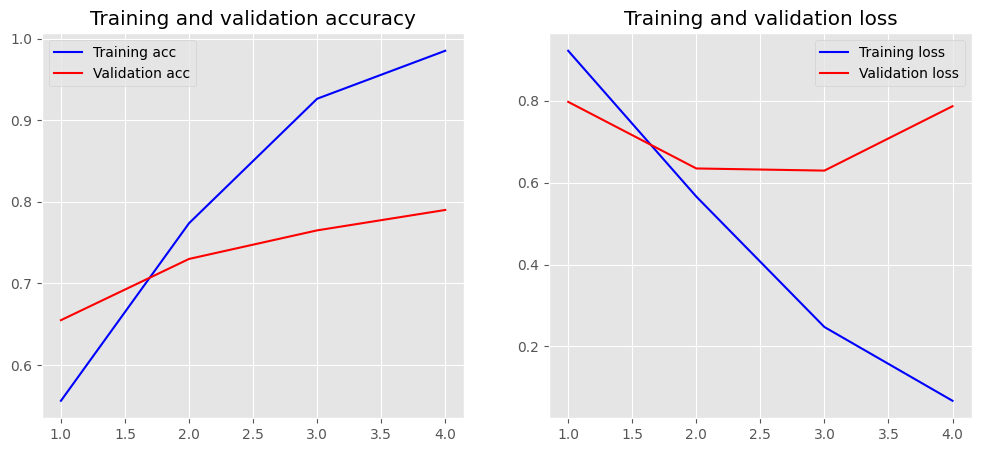

In [29]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title("Training and validation accuracy")
    plt.legend()

    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title("Training and validation loss")
    plt.legend()

%matplotlib inline
plot_history(history)

# Prediksi data baru

In [30]:
import re, pickle
import numpy as np
from keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [31]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
input_text = """Ibu pernah bekerja di grab indonesia"""

In [32]:
def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [ ]:
sentiment = ['negative','neutral','positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
print(text)

file = open("API/resources_of_lstm/x_pad_sequences.pickle",'rb')
feature_file_from_lstm = pickle.load(file)
guess = pad_sequences(predicted, maxlen=feature_file_from_lstm.shape[1])
print(guess)

model = load_model("API/model_of_lstm/model_lstm.keras")
prediction = model.predict(guess)
print(prediction)
polarity = np.argmax(prediction[0])

print("Text: ", text[0])
print("Sentiment: ", sentiment[polarity])